In [12]:
import sys
sys.path.insert(1, "./KLines")

In [13]:
import numpy as np
import copy
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from klines import SetOfLines, SetOfPoints, CorsetForKMeansForLines, CoresetForWeightedCenters, CoresetStreamer, CoresetNode

In [14]:
## data
k = 3
d = 2
N = int(1e4)
m = max(100, int(N/1e2))  # coreset size ~ reduction ratio
tau = 1e-3

In [15]:
straight_roads = np.load('road_segments_china.npy') # 8.7e5 entries
straight_roads = straight_roads[:N]
# straight_roads = straight_roads[np.random.choice(straight_roads.shape[0], N, replace=False)]
L = [[x[0][0], x[0][1], x[1][0], x[1][1]] for x in straight_roads]

In [16]:
## construct set of lines
L = SetOfLines([], [], [], [], L, True)

In [17]:
class ParameterConfig:
    def __init__(self):
        pass

In [18]:
config = ParameterConfig()

config.a_b_approx_minimum_number_of_lines = int(N*0.01) # constant 100, line 2, algo 2 BI-CRITERIA

config.sample_size_for_a_b_approx = int(m*1.01) # |S| >= m, line 3 of algo 2
                                                # note: there'll be a O(|S|^2) cost while computing algo 1
    
config.farthest_to_centers_rate_in_a_b_approx = 4.0/11  # opp of 7/11, line 6, algo 2 BI-CRITERIA
config.number_of_remains_multiply_factor = int(math.log(N))//k # this is `b` in algo 2, other paper, set as random here -  how to calculate it?
config.closest_to_median_rate = (1-tau)/(2*k)  # refer line 4, algo 1, other paper

config.median_sample_size = int(N*0.05)    # size of q_i, line 3, algo 2, other paper
config.max_sensitivity_multiply_factor = 50  # for outliers in coresets

In [25]:
# define the streamer
SAMPLE_SIZE = 55   # coreset size grws linear w/ SAMPLE_SIZE
streamer = CoresetStreamer(SAMPLE_SIZE, N, k, config)

In [26]:
# note this is O(sample^2 * n) + O(m)
# N ~ 1e4 took 50s
# N ~ 1e5 took 350s
# N ~ 1e6 took 3000s
coreset = streamer.stream(L)
print(f"Time taken: {coreset[2]-coreset[1]}s")

Lines read so far:  0
coreset sum of weights:  9999.999999999998
Time taken: 80.27141284942627s


## Graphical Analysis

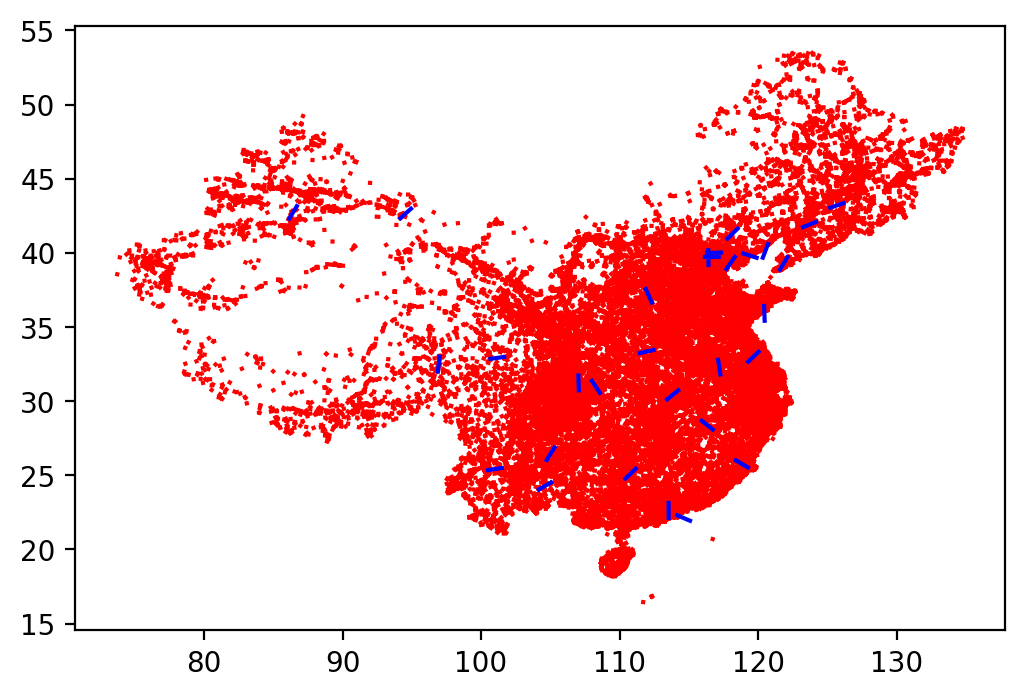

In [87]:
S1 = coreset[0]

for r in straight_roads:
    plt.plot([r[0][0], r[1][0]], [r[0][1], r[1][1]], 'r')

for i in range(len(S1.spans)):
    v1 = S1.displacements[i]
    v12 = S1.spans[i]
    v2 = v1 - v12
    plt.plot([v1[0], v2[0]], [v1[1], v2[1]], 'b')
    
plt.rcParams['figure.dpi'] = 200 
plt.show()

## Comparision with offline computing

### This is n^2, will work only when n<1e3

In [40]:
coreset_offline, B, _ = CorsetForKMeansForLines(config).coreset(L, k, m, True)

KeyboardInterrupt: 

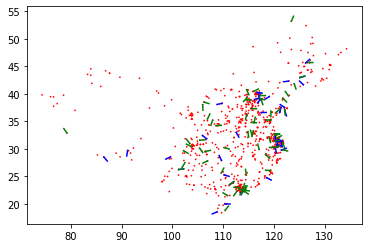

In [27]:
S1 = coreset[0]
S2 = coreset_offline

for r in straight_roads:
    plt.plot([r[0][0], r[1][0]], [r[0][1], r[1][1]], 'r')

for i in range(len(S1.spans)):
    v1 = S1.displacements[i]
    v12 = S1.spans[i]
    v2 = v1 - v12
    plt.plot([v1[0], v2[0]], [v1[1], v2[1]], 'b')
    
for i in range(len(S2.spans)):
    v1 = S2.displacements[i]
    v12 = S2.spans[i]
    v2 = v1 - v12
    plt.plot([v1[0], v2[0]], [v1[1], v2[1]], 'g')
    
plt.rcParams['figure.dpi'] = 200 
plt.show()

In [32]:
S1.get_sum_of_distances_to_centers(B)  #streaming

3.0681387132435614

In [29]:
S2.get_sum_of_distances_to_centers(B)  #offline

3.7899735408246107